The steps involved in this code:

1. Load the IMU quotarnion data
2. Def'n of the Functions for calculating the wanted angles
3. Plotting to see what function gives better answer


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cosine
from matplotlib.animation import FuncAnimation, writers
import matplotlib.colors as mcolors

# Loading Data


In [2]:
folder_name = "20250524_173857"
folder_path = os.path.join("/home/jafarid/code/fusion/DataLogger", folder_name)
angles = ["Back", "Shoulder_Flex_Ext","Shoulder_Add_Abd", "Shoulder_Rotation", "Elbow_Flex_Ext", "Hand_ROM"]
ANGLE_TO_DISPLAY = angles[2]


# Global Variables 
N_FIRST_REF_FRAMES = 150
USER_HEIGHT = 1.62


files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

imu_data = {}
for file in files:
    parts = file.split("_")
    imu_id = parts[0]  # e.g., "IMU-1", "IMU-2", etc.
    if "quaternion" not in file:
        continue  # only process quaternion logs

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    if "timestamp" not in df.columns:
        if "Time" in df.columns:
            df.rename(columns={"Time": "timestamp"}, inplace=True)
        else:
            print(f"'timestamp' column missing in {imu_id}. Columns found: {df.columns.tolist()}")
            continue

    imu_data.setdefault(imu_id, {})["quaternion_log"] = df.sort_values("timestamp")

# Use only those with valid data
processed_data = {imu: data["quaternion_log"] for imu, data in imu_data.items() if "quaternion_log" in data}
if not processed_data:
   raise ValueError("No valid data processed. Please check input files.")

# Determine number of frames (using the smallest dataframe length)
num_frames = min(len(df) for df in processed_data.values())
if num_frames == 0:
    raise ValueError("No valid frames to animate.")

print('The total number of frames are: {}'.format(num_frames))

The total number of frames are: 2067


### Anthropometric segment length of human body as a function of body height


In [3]:
lower_back_length = 0.1 * USER_HEIGHT
upper_back_length = 0.139 * USER_HEIGHT
shoulder_length = 0.129 * USER_HEIGHT
upper_arm_length = 0.186 * USER_HEIGHT
lower_arm_length = 0.145 * USER_HEIGHT
hand_length = 0.108 * USER_HEIGHT


In [4]:
# helper functions 

def angle_between(v1, v2):
    """Calculate the angle (in degrees) between two 3D vectors."""
    dot_val = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 * norm_v2 < 1e-12:
        return 0.0
    cos_theta = np.clip(dot_val / (norm_v1 * norm_v2), -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def normalize_quaternion(q):
    """
    Normalize a quaternion to unit length.
    q: array-like [w, x, y, z]
    """
    q = np.asarray(q, dtype=float)
    return q / np.linalg.norm(q)

def quaternion_conjugate(q):
    """
    Compute the conjugate of a quaternion.
    q: array-like [w, x, y, z]
    returns [w, -x, -y, -z]
    """
    w, x, y, z = q
    return np.array([w, -x, -y, -z], dtype=float)

def quaternion_multiply(q1, q2):
    """
    Hamilton product of two quaternions.
    q1, q2: array-like [w, x, y, z]
    returns q1 ⊗ q2
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z], dtype=float)

def compute_relative_quaternion(q_ref, q_2):
    """
    Compute the relative quaternion q_rel = q_ref^{-1} ⊗ q_2.
    relative q_ref wrt q_2
    q_ref, q_2: array-like [w, x, y, z]
    returns q_rel normalized to unit length.
    """
    # Normalize inputs
    q_s = normalize_quaternion(q_ref)
    q_a = normalize_quaternion(q_2)
    # Inverse of a unit quaternion is its conjugate
    q_s_inv = quaternion_conjugate(q_s)
    # Relative rotation
    q_rel = quaternion_multiply(q_s_inv, q_a)
    # Normalize result to guard against numerical drift
    return normalize_quaternion(q_rel)

def compute_relative_angle(q_rel):
    """
    Compute the rotation angle θ (in radians) represented by a unit quaternion.

    Parameters
    ----------
    q_rel : array-like of shape (4,)
        The relative quaternion [w, x, y, z].

    Returns
    -------
    theta : float
        The rotation angle θ in radians, in [0, π].
    """
    # Convert to NumPy array and ensure float type
    q = np.asarray(q_rel, dtype=float)
    # Normalize to guard against drift
    q /= np.linalg.norm(q)
    w = np.clip(q[0], -1.0, 1.0)  # scalar part

    # Method 1: using arccos
    theta = 2 * np.arccos(w)   # angle in radians

    # Alternative (more stable for small angles):
    # v_norm = np.linalg.norm(q[1:])
    # theta = 2 * np.arctan2(v_norm, w)
    
    theta = np.degrees(theta)   # convert to degrees

    return theta

def set_axes_equal(ax):
    """Set 3D plot axes to equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)
    mid_x, mid_y, mid_z = np.mean(x_limits), np.mean(y_limits), np.mean(z_limits)
    ax.set_xlim3d([mid_x - max_range/2, mid_x + max_range/2])
    ax.set_ylim3d([mid_y - max_range/2, mid_y + max_range/2])
    ax.set_zlim3d([mid_z - max_range/2, mid_z + max_range/2])
    
def init_angle_plots(ax, labels_list, styles_list):
    """
    Create one Line2D per data series on ax, with given styles/labels.
    All lines start empty ([]). Returns list of Line2D objects.
    """
    lines = []
    for label, style in zip(labels_list, styles_list):
        line, = ax.plot([], [], style, label=label)
        lines.append(line)
    ax.legend()
    return lines


### KInematic Chain Definition


In [5]:
# Skeleton (kinematic chain) parameters
ROOT_ID = "ROOT"
# Ordered hierarchy for sequential processing
imu_chain_order = ["IMU-6", "IMU-5", "IMU-4", "IMU-3", "IMU-2", "IMU-1"]
imu_hierarchy = {
    "IMU-6": (ROOT_ID, lower_back_length),
    "IMU-5": ("IMU-6", upper_back_length),
    "IMU-4": ("IMU-5", shoulder_length),
    "IMU-3": ("IMU-4", upper_arm_length),
    "IMU-2": ("IMU-3", lower_arm_length),
    "IMU-1": ("IMU-2", hand_length),
}
unit_vectors = {
    "IMU-6": np.array([-1,  0,  0]),
    "IMU-5": np.array([-1,  0,  0]),
    "IMU-4": np.array([ 0,  1,  0]),
    "IMU-3": np.array([ 1,  0,  0]),
    "IMU-2": np.array([ 1,  0,  0]),
    "IMU-1": np.array([ 1,  0,  0]),
}

Reference Frame Averaging


In [6]:
# Store reference (first_n_frames average) quaternions for each IMU (reorder to [x, y, z, w])
reference_quaternions = {}
reference_matrices = {}

cols = ["q1", "q2", "q3", "q0"]
for imu_id, df in processed_data.items():
    # take the first N_FIRST_REF_FRAMES rows of those columns starting from frame 50 start
    # pick rows 50-N_FIRST_REF_FRAMES(inclusive of 50, exclusive of N_FIRST_REF_FRAMES)
    ref_block = df[cols].iloc[50:N_FIRST_REF_FRAMES]
    # compute the mean for each quaternion component
    q_mean = ref_block.mean().to_numpy()
    q_mean = q_mean / np.linalg.norm(q_mean)      # normalize to unit length
    
    reference_quaternions[imu_id] = q_mean
    
    R_mean = R.from_quat(q_mean)
    reference_matrices[imu_id] = R_mean

#print(reference_quaternions)

v_x = np.array([1, 0, 0])
v_z = np.array([0, 0, 1])
thetas = []
R_z_thetas = []
ref_pos = {ROOT_ID: np.zeros(3)}        # put the root at the origin
for imu in imu_chain_order:
    # make sure we actually know this IMU’s reference quaternion
    if imu not in reference_quaternions:
        continue

    quat = reference_quaternions[imu]   # <-- use *imu*, not imu_id
    R_ref = R.from_quat(quat)           # quat is [x, y, z, w]
    R_ref_inv = R_ref.inv()
    #print(R_ref_inv.as_matrix())
    z_i_calb = R_ref_inv.apply(v_z)
    #print(z_i_calb)
    theta = angle_between(v_x, z_i_calb)
    thetas.append(theta)
    
    R_z_theta = R.from_euler('z', theta)
    R_z_thetas.append(R_z_theta)
    parent, seg_length = imu_hierarchy[imu]
    child_vec = unit_vectors[imu] * seg_length

    # parent must already have a position (guaranteed by the chain order)
    if parent not in ref_pos:
        raise KeyError(f"Parent {parent} is missing from ref_pos")

    # world-space position of this IMU in the reference pose
    ref_pos[imu] = R_ref.apply(child_vec) + ref_pos[parent]

print(ref_pos)
print(thetas)

{'ROOT': array([0., 0., 0.]), 'IMU-6': array([0.00608869, 0.00514763, 0.16180368]), 'IMU-5': array([ 0.02229456, -0.01025061,  0.38587129]), 'IMU-4': array([-0.06489541,  0.1788045 ,  0.36774078]), 'IMU-3': array([-0.11365506,  0.25312148,  0.07982894]), 'IMU-2': array([-0.19254264,  0.29888064, -0.13664474]), 'IMU-1': array([-0.22711172,  0.35896481, -0.29728681])}
[177.17895606048205, 174.30256906582602, 162.68100844342894, 162.84336889296742, 157.1547437724281, 156.65920627786193]


Adding utility functions below


Adding variables to store the computed angle values


In [7]:
### ROM ANGLES ###
# Preallocate arrays for angle measures

# vector angle canculations using two set of IMU data to define a vector
# and calculate the angle using cosine inverse formula


# Shoulder is calculated as the angle between IMU 2 and 3 & IMU 5 & 6 
shoulder_vector_angle  = np.full(num_frames, np.nan)

# considering only IMU 3 and IMU 5  
shoulder_2imudot_angle = np.full(num_frames, np.nan)

# Elbow is calculated as the angle between IMU 1 and 2 & IMU 5 & 6 
elbow_vector_angle      = np.full(num_frames, np.nan)
elbow_2imudot_angle = np.full(num_frames, np.nan)
# TO DO LATER: Find the ref R and subtract from the R_realtime


# Data record lists for subsequent export

imu1_hand_data_records = []
imu2_elbow_data_records = []
imu3_shoulder_data_records = []  # [frame, roll, pitch (shoulder_flexion), yaw (shoulder_abduction)]
imu4_shoulder_data_records = []   # [frame, imu4_roll, imu4_pitch, imu4_yaw]
imu5_trunk_data_records = [] # [frame, imu5_roll, imu5_pitch, imu5_yaw]
imu6_trunk_data_records = [] # [frame, imu6_roll, imu6_pitch, imu6_yaw]

# Angle definitions to be stored 

# wrist sup/pron
wrist_data_records          = []  # [frame, sensor, wrist_pronation_supination_deg]

# elbow flex/ext
elbow_data_records          = []  # [frame, elbow_flexion_extension_deg] (yaw from IMU-2)

# shoulder abd/add and shoulder flex/ext
shoulder_movement_records = []

# shoulder internal/external rotation 
shoulder_rotation_data_records = []  # [frame, shoulder_rotation_deg]

imu5_6_data_records = []
imu4_6_data_records = []
imu3_6_data_records = []
### COMPENSATORY MOTIONS ###

## Trunk movements: slouching, side melting, rotation
# POTENTIAL Def'ns below 
    # the yaw, pitch, roll change of IMU5 and IMU6​
    # Look at the dot product between IMU5 and Imu6 (abs angle)​
    # qrel =q5 q6^−1 and converting qrel  directly to Euler angle to find the relative angle of 5 wrt 6 ​

trunk_data_records  = [] # [frame, imu6_dot_imu5, q5rel6_roll , q5rel6_pitch, q5rel6_yaw]

# Shoulder movements: shoulder_elevation, shoulder_protraction
# POTENTIAL Def'ns below 
shoulder_elevation = np.zeros(num_frames)
shoulder_retraction= np.zeros(num_frames)


# Elbow movement: move away from the body during shoulder rotation 
# POTENTIAL Def'ns below 

Calculating Angles below


In [8]:
# A list of dictionaries storing the skeleton node positions at each frame
positions_list = []

# Loop over all frames; compute positions and record joint angles
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.array([0, 0, 0])}  # reinitialize for each frame
    x_imu3 = None  # will store current x-axis vector for IMU-3
    x_imu2 = None
    x_imu5 = None  # will store current x-axis vector for IMU-5

    for imu in imu_chain_order:
        if imu not in processed_data:
            continue

        # Get current quaternion (reorder to [x, y, z, w])
        quats = processed_data[imu][["q0", "q1", "q2", "q3"]].values
        q_cur = quats[frame, [1, 2, 3, 0]]
        R_cur = R.from_quat(q_cur)
        
        # Compute relative rotation from reference (frame 0)
        #q_ref = reference_quaternions[imu]
        #R_ref = R.from_quat(q_ref)
        #roll_ref, pitch_ref, yaw_ref = R_ref.as_euler('xyz', degrees=True)
        
        # TO DO: the below equation gives wrong answer, CHECK OUT HOW TO DO THE DIFF
        #R_diff = R_ref.inv() * R_cur
        
        roll, pitch, yaw = R_cur.as_euler('xyz', degrees=True)
        
        # ANOTHER WAY TO DO DIFF FROM ANGLES 
        #roll_diff, pitch_diff, yaw_diff = roll- roll_ref, pitch- pitch_ref, yaw - yaw_ref
        
        
        # Update segment position using the hierarchical relationship
        parent, seg_length = imu_hierarchy[imu]
        child_vec = unit_vectors[imu] * seg_length
        # Assumes parent's position already computed in this frame
        seg_pos[imu] = R_cur.apply(child_vec) + seg_pos[parent]
        
        # using queternion method 
        #q_rel = compute_relative_quaternion(q_ref,q_cur)
        #theta = compute_relative_angle(q_rel)
        
        
        
        
        if imu == "IMU-1":
            imu1_hand_data_records.append([frame, roll, pitch, yaw])
            wrist_data_records.append([frame, "Hand", roll])
        if imu == "IMU-2":
            elbow_data_records.append([frame, yaw])
            # Adjust for shoulder rotation computation
            R_adjust = R.from_euler('z', 90, degrees=True)
            R_diff_adjusted = (R_adjust * R_ref).inv() * R_cur
            _, adjusted_pitch, _ = R_diff_adjusted.as_euler('xyz', degrees=True)
            shoulder_rotation_data_records.append([frame, adjusted_pitch])
            wrist_data_records.append([frame, "Elbow", roll])
            imu2_elbow_data_records.append([frame, roll, pitch, yaw])
            x_imu2 = R_cur.apply(np.array([1, 0, 0]))
        if imu == "IMU-3":
            imu3_shoulder_data_records.append([frame, roll, pitch, yaw])
            x_imu3 = R_cur.apply(np.array([1, 0, 0]))
            
        if imu == "IMU-4":
            imu4_shoulder_data_records.append([frame, roll, pitch, yaw])
            
        if imu == "IMU-5":
            imu5_trunk_data_records.append([frame, roll, pitch, yaw])
            x_imu5 = R_cur.apply(np.array([1, 0, 0]))
        if imu == "IMU-6":
            imu6_trunk_data_records.append([frame, roll, pitch, yaw])
            
        # for continous compensation movements here we calculate
        
       
        
    positions_list.append(seg_pos)
    
    
    
    # Compute global shoulder angle if possible
    if all(k in seg_pos for k in ["IMU-6", "IMU-5", "IMU-3", "IMU-2"]):
        v_chest = seg_pos["IMU-5"] - seg_pos["IMU-6"]
        v_upper = seg_pos["IMU-3"] - seg_pos["IMU-2"]
        shoulder_vector_angle[frame]= angle_between(v_chest, v_upper)
    # Compute global elbow angle if possible
    if all(k in seg_pos for k in ["IMU-3", "IMU-2", "IMU-1"]):
        v_upper_arm = seg_pos["IMU-3"] - seg_pos["IMU-2"]
        v_forearm = seg_pos["IMU-2"] - seg_pos["IMU-1"]
        elbow_vector_angle[frame] = angle_between(v_upper_arm, v_forearm)
        
    # Compute shoulder elevation/retraction from IMU-4 relative to IMU-5's local frame
    if "IMU-4" in seg_pos and "IMU-5" in seg_pos:
        v = seg_pos["IMU-4"] - seg_pos["IMU-5"]
        q_cur5 = processed_data["IMU-5"].iloc[frame][["q1", "q2", "q3", "q0"]].values
        R5 = R.from_quat(q_cur5)
        v_local = R5.inv().apply(v)
        shoulder_elevation[frame] = v_local[2]
        shoulder_retraction[frame] = v_local[0]
        
    # Compute the dot product-based angle between IMU-3 and IMU-5 x-axes if available
    if x_imu3 is not None and x_imu5 is not None:
        dot_val = np.clip(np.dot(x_imu3, x_imu5), -1.0, 1.0)
        shoulder_2imudot_angle[frame] = np.degrees(np.arccos(dot_val))
        
    if x_imu3 is not None and x_imu2 is not None:
        dot_val = np.clip(np.dot(x_imu3, x_imu2), -1.0, 1.0)
        elbow_2imudot_angle[frame] = np.degrees(np.arccos(dot_val))
    elbow_2imudot_angle
        
    ### COMPENSATIONS 
    # TRUNK
    q_2 = processed_data["IMU-2"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_3 = processed_data["IMU-3"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_4 = processed_data["IMU-4"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_5 = processed_data["IMU-5"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_6 = processed_data["IMU-6"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    
    R_n_2 = reference_matrices["IMU-2"]
    R_n_2 = R_n_2.inv()
    R_2 = R.from_quat(q_2)
    
    q_rel = compute_relative_quaternion(q_5, q_6)
    R_rel = R.from_quat(q_rel)
    roll_rel, pitch_rel, yaw_rel = R_rel.as_euler('xyz', degrees=True)
    trunk_data_records.append([frame, roll_rel, pitch_rel, yaw_rel]) #[frame, q5rel6_roll , q5rel6_pitch, q5rel6_yaw]
      #R_ref = R.from_quat(q_ref)
        #roll_ref, pitch_ref, yaw_ref = R_ref.as_euler('xyz', degrees=True)
    R_6 = R.from_quat(q_6)
    R_5 = R.from_quat(q_5)
    R_4 = R.from_quat(q_4)
    R_3 = R.from_quat(q_3)
    R_2 = R.from_quat(q_2)
    R_6_T = R_6.inv()
    
    R_5_6 = R_6_T * R_5
    R_4_6 = R_6_T * R_4
    
    roll_deg = 90
    rotation_matrix = R.from_euler('x', roll_deg, degrees=True)
    R_3 = rotation_matrix * R_3
    R_3_6 = R_6_T * R_3
    R_2_6 = R_6_T * R_2
    
    roll_5_6, pitch_5_6, yaw_5_6 = R_5_6.as_euler('xyz', degrees=True)
    imu5_6_data_records.append([frame, roll_5_6, pitch_5_6, yaw_5_6])
    
    roll_4_6, pitch_4_6, yaw_4_6 = R_4_6.as_euler('xyz', degrees=True)
    imu4_6_data_records.append([frame, roll_4_6, pitch_4_6, yaw_4_6])
    
    roll_3_6, pitch_3_6, yaw_3_6 = R_3_6.as_euler('xyz', degrees=True)
    imu3_6_data_records.append([frame, roll_3_6, pitch_3_6, yaw_3_6])
    

In [9]:
# testing out n pose to ground inverse multiplied by imu r real time wrt to ground to obtain the imu real time wrt to n pose


positions_list_wrt_n = []

# Loop over all frames; compute positions and record joint angles
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.array([0, 0, 0])}  # reinitialize for each frame
   
    for imu in imu_chain_order:
        if imu not in processed_data:
            continue

        # Get current quaternion (reorder to [x, y, z, w])
        quats = processed_data[imu][["q0", "q1", "q2", "q3"]].values
        q_cur = quats[frame, [1, 2, 3, 0]]
        
        R_n = reference_matrices[imu]
        
        R_n_inv = R_n.inv()
        
        R_rt = R.from_quat(q_cur)
       
        R_rt_n = R_n_inv * R_rt
       
        R_z_theta = R_z_thetas[imu_chain_order.index(imu)]
        
        R_body_ref = R_z_theta.inv() * R_rt * R_n_inv * R_z_theta
        # Compute relative rotation from reference (frame 0)
        
        # Update segment position using the hierarchical relationship
        parent, seg_length = imu_hierarchy[imu]
        child_vec = unit_vectors[imu] * seg_length
        # Assumes parent's position already computed in this frame
        seg_pos[imu] = R_body_ref.apply(child_vec) + seg_pos[parent]
        
        # using queternion method 
        #q_rel = compute_relative_quaternion(q_ref,q_cur)
        #theta = compute_relative_angle(q_rel)
        
               
        
    positions_list_wrt_n.append(seg_pos)
    

In [10]:
# Prepare storage for each pair
imu_pairs = [(i, i+1) for i in range(1, 6)]
relative_records = {pair: [] for pair in imu_pairs}

# Determine the number of frames common to all IMUs
num_frames = min(len(df) for df in processed_data.values())

for idx in range(num_frames):
    # If you want the true “frame” label, and your DataFrame index ARE the frame numbers:
    frame_label = processed_data["IMU-1"].index[idx]
    # Otherwise, if you have a column named 'frame', use:
    # frame_label = processed_data["IMU-1"].iloc[idx]['frame']

    for (i, j) in imu_pairs:
        # extract [q1, q2, q3, q0] as numpy arrays
        qi = processed_data[f"IMU-{i}"].iloc[idx][["q1","q2","q3","q0"]].to_numpy()
        qj = processed_data[f"IMU-{j}"].iloc[idx][["q1","q2","q3","q0"]].to_numpy()

        # compute relative quaternion and convert to Euler angles
        q_rel = compute_relative_quaternion(qi, qj)
        roll_rel, pitch_rel, yaw_rel = R.from_quat(q_rel).as_euler('xyz', degrees=True)

        # append [frame, roll, pitch, yaw] to the right list
        relative_records[(i, j)].append([frame_label, roll_rel, pitch_rel, yaw_rel])

# After this loop:
#   relative_records[(1,2)] holds q1→q2 euler angles,
#   relative_records[(2,3)] holds q2→q3, …,
#   relative_records[(5,6)] holds q5→q6 (your trunk_data_records)

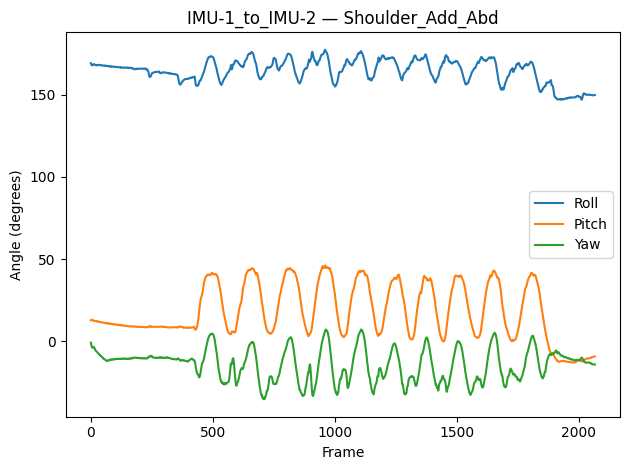

Saved plot for IMU-1_to_IMU-2 to /home/jafarid/code/xio/Results/IMU-1_to_IMU-2_Shoulder_Add_Abd_relative_xyz_angles/IMU-1_to_IMU-2_Shoulder_Add_Abd_relative_xyz_angles.png


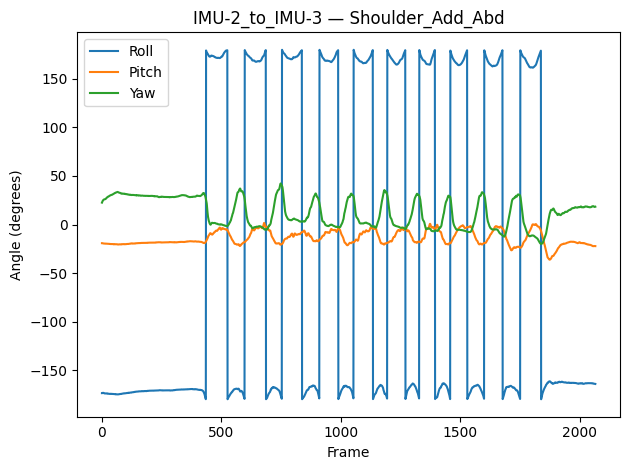

Saved plot for IMU-2_to_IMU-3 to /home/jafarid/code/xio/Results/IMU-2_to_IMU-3_Shoulder_Add_Abd_relative_xyz_angles/IMU-2_to_IMU-3_Shoulder_Add_Abd_relative_xyz_angles.png


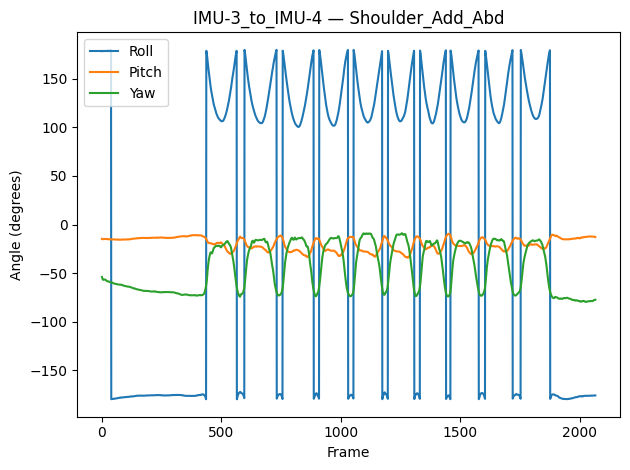

Saved plot for IMU-3_to_IMU-4 to /home/jafarid/code/xio/Results/IMU-3_to_IMU-4_Shoulder_Add_Abd_relative_xyz_angles/IMU-3_to_IMU-4_Shoulder_Add_Abd_relative_xyz_angles.png


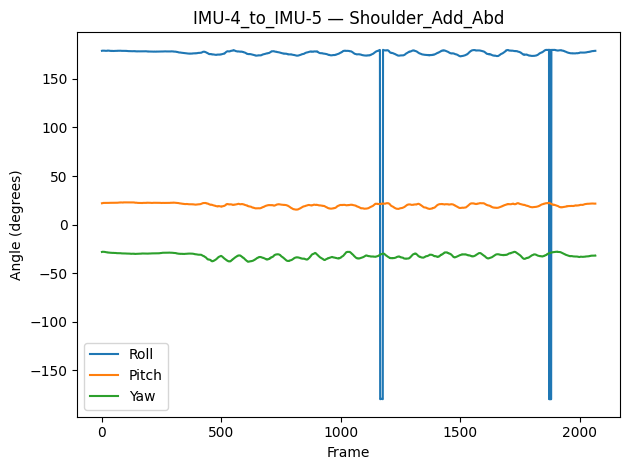

Saved plot for IMU-4_to_IMU-5 to /home/jafarid/code/xio/Results/IMU-4_to_IMU-5_Shoulder_Add_Abd_relative_xyz_angles/IMU-4_to_IMU-5_Shoulder_Add_Abd_relative_xyz_angles.png


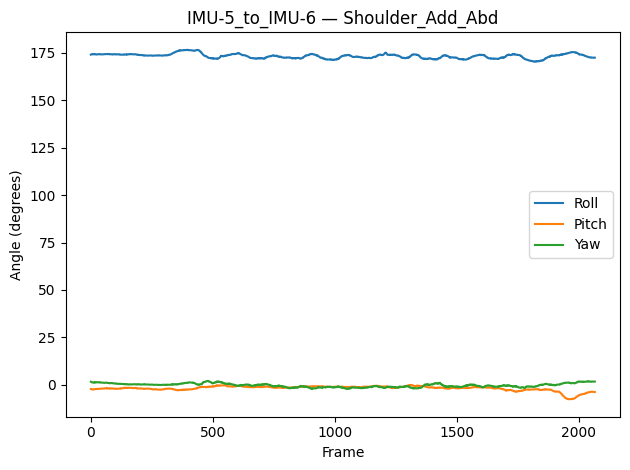

Saved plot for IMU-5_to_IMU-6 to /home/jafarid/code/xio/Results/IMU-5_to_IMU-6_Shoulder_Add_Abd_relative_xyz_angles/IMU-5_to_IMU-6_Shoulder_Add_Abd_relative_xyz_angles.png


In [11]:
# Base results directory
base_results_dir = "/home/jafarid/code/xio/Results"


for (i, j), records in relative_records.items():
    if not records:
        continue  # skip empty records
    
    # Convert to NumPy array for slicing
    data = np.array(records)
    frames    = data[:, 0]
    roll_rel  = data[:, 1]
    pitch_rel = data[:, 2]
    yaw_rel   = data[:, 3]
    
    # Construct names and paths
    pair_name  = f"IMU-{i}_to_IMU-{j}"
    ani_name   = f"{pair_name}_{ANGLE_TO_DISPLAY}_relative_xyz_angles"
    folder_path = os.path.join(base_results_dir, ani_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # Plot
    plt.figure()
    plt.plot(frames, roll_rel,  label="Roll")
    plt.plot(frames, pitch_rel, label="Pitch")
    plt.plot(frames, yaw_rel,   label="Yaw")
    plt.xlabel("Frame")
    plt.ylabel("Angle (degrees)")
    plt.title(f"{pair_name} — {ANGLE_TO_DISPLAY}")
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    file_name = f"{pair_name}_{ANGLE_TO_DISPLAY}_relative_xyz_angles.png"
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)
    plt.show()
    
    print(f"Saved plot for {pair_name} to {file_path}")

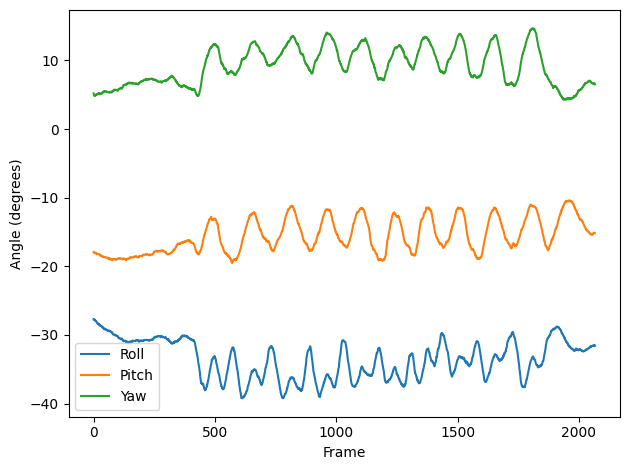

In [12]:
 # Convert to NumPy array for slicing
data = np.array(imu4_6_data_records)
frames    = data[:, 0]
roll_rel  = data[:, 1]
pitch_rel = data[:, 2]
yaw_rel   = data[:, 3]

# Construct names and paths


# Plot
plt.figure()
plt.plot(frames, roll_rel,  label="Roll")
plt.plot(frames, pitch_rel, label="Pitch")
plt.plot(frames, yaw_rel,   label="Yaw")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")

plt.legend()
plt.tight_layout()

# Save figure

plt.show()

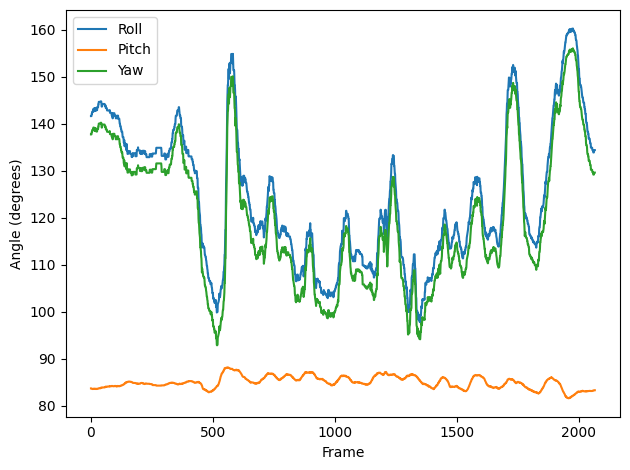

In [13]:
 # Convert to NumPy array for slicing
data = np.array(imu5_trunk_data_records)
frames    = data[:, 0]
roll_rel  = data[:, 1]
pitch_rel = data[:, 2]
yaw_rel   = data[:, 3]

# Construct names and paths


# Plot
plt.figure()
plt.plot(frames, roll_rel,  label="Roll")
plt.plot(frames, pitch_rel, label="Pitch")
plt.plot(frames, yaw_rel,   label="Yaw")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")

plt.legend()
plt.tight_layout()

# Save figure

plt.show()

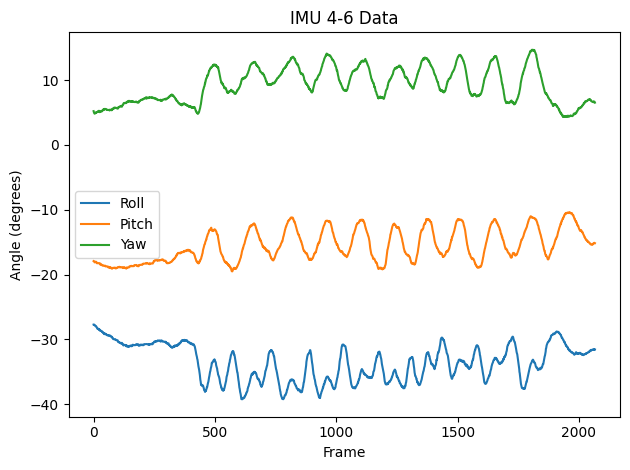

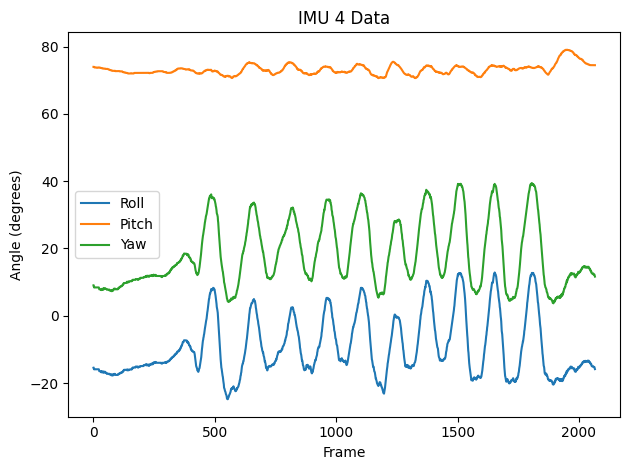

In [14]:
def plot_imu_data(records, title):
    data = np.array(records)
    frames    = data[:, 0]
    roll_rel  = data[:, 1]
    pitch_rel = data[:, 2]
    yaw_rel   = data[:, 3]

    plt.figure()
    plt.plot(frames, roll_rel,  label="Roll")
    plt.plot(frames, pitch_rel, label="Pitch")
    plt.plot(frames, yaw_rel,   label="Yaw")
    plt.xlabel("Frame")
    plt.ylabel("Angle (degrees)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
plot_imu_data(imu4_6_data_records, "IMU 4-6 Data")
plot_imu_data(imu4_shoulder_data_records, "IMU 4 Data")

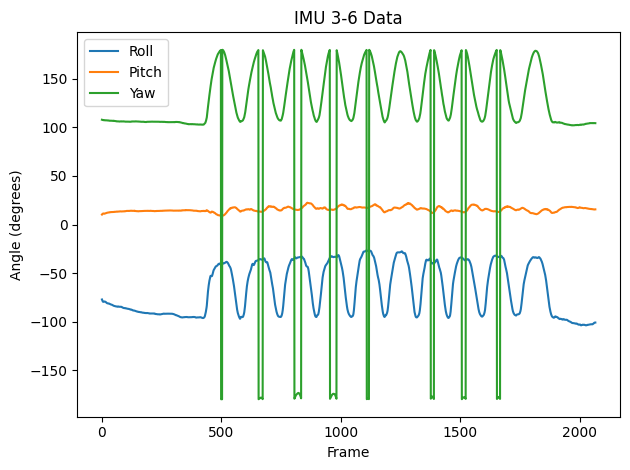

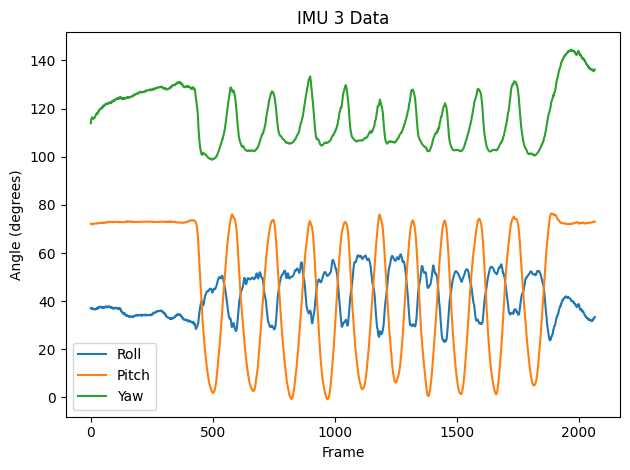

In [15]:
plot_imu_data(imu3_6_data_records, "IMU 3-6 Data")

plot_imu_data(imu3_shoulder_data_records, "IMU 3 Data")

Plotting calculated angles


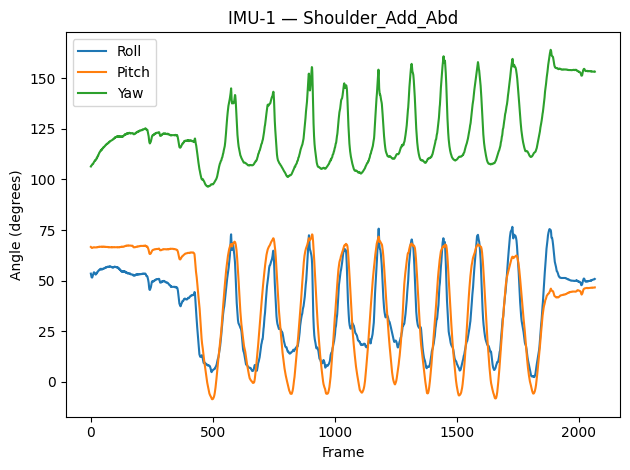

<Figure size 640x480 with 0 Axes>

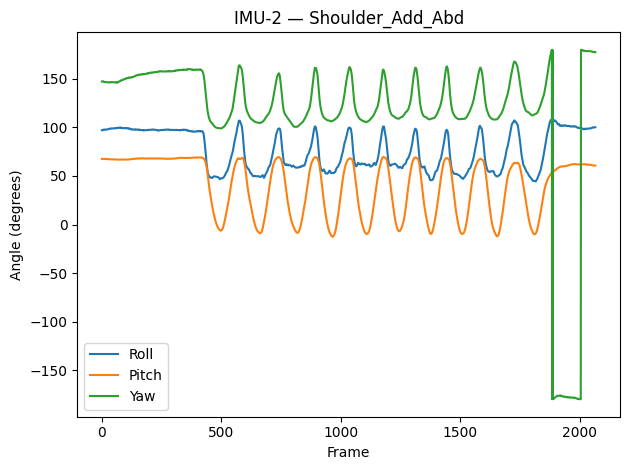

<Figure size 640x480 with 0 Axes>

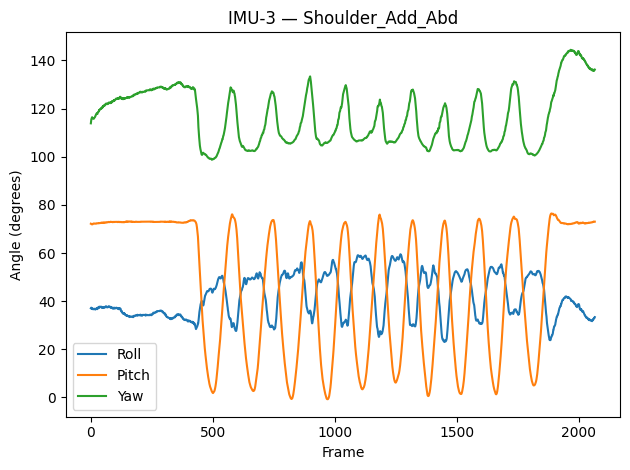

<Figure size 640x480 with 0 Axes>

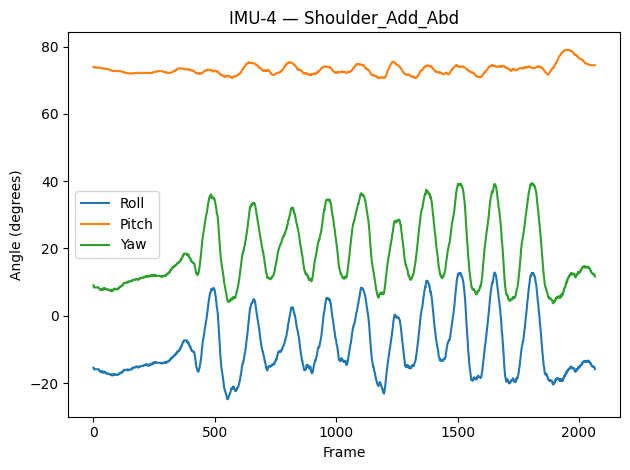

<Figure size 640x480 with 0 Axes>

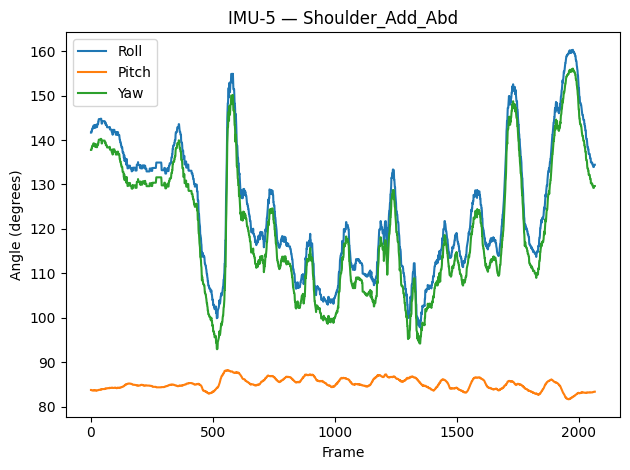

<Figure size 640x480 with 0 Axes>

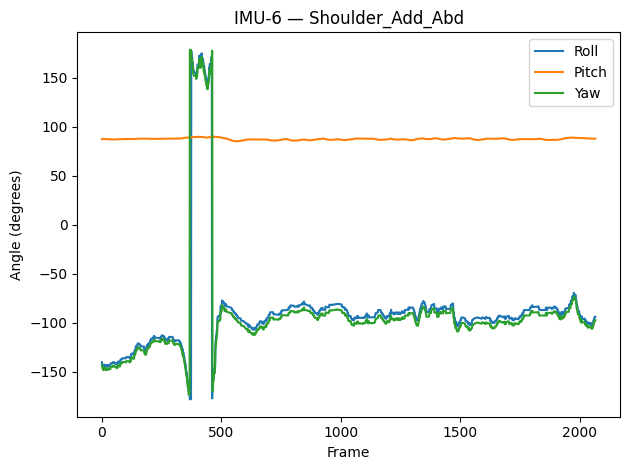

<Figure size 640x480 with 0 Axes>

In [16]:
# for Abs IMU data 

folder_path= "/home/jafarid/code/xio/Results/"

imu_data_records = {
    "IMU-1": imu1_hand_data_records,
    "IMU-2": imu2_elbow_data_records,
    "IMU-3": imu3_shoulder_data_records,
    "IMU-4": imu4_shoulder_data_records,
    "IMU-5": imu5_trunk_data_records,
    "IMU-6": imu6_trunk_data_records,
}

for imu_name, records in imu_data_records.items():
    # Skip if no data
    if not records:
        continue

    # Convert to NumPy array for easy slicing
    data = np.array(records)  
    frames = data[:, 0]
    roll   = data[:, 1]
    pitch  = data[:, 2]
    yaw    = data[:, 3]

    # Create a new figure for this IMU
    plt.figure()
    plt.plot(frames, roll,  label="Roll")
    plt.plot(frames, pitch, label="Pitch")
    plt.plot(frames, yaw,   label="Yaw")
    plt.xlabel("Frame")
    plt.ylabel("Angle (degrees)")
    plt.title(f"{imu_name} — {ANGLE_TO_DISPLAY}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    file_name = f"{ANGLE_TO_DISPLAY}_{imu_name}_xyz_angles.png"
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)





In [17]:
# for relative imu data

In [18]:
# 2D PLOTS of various angle definitions and compesatory movements

Animation saved as: animation_Shoulder_Add_Abd.mov


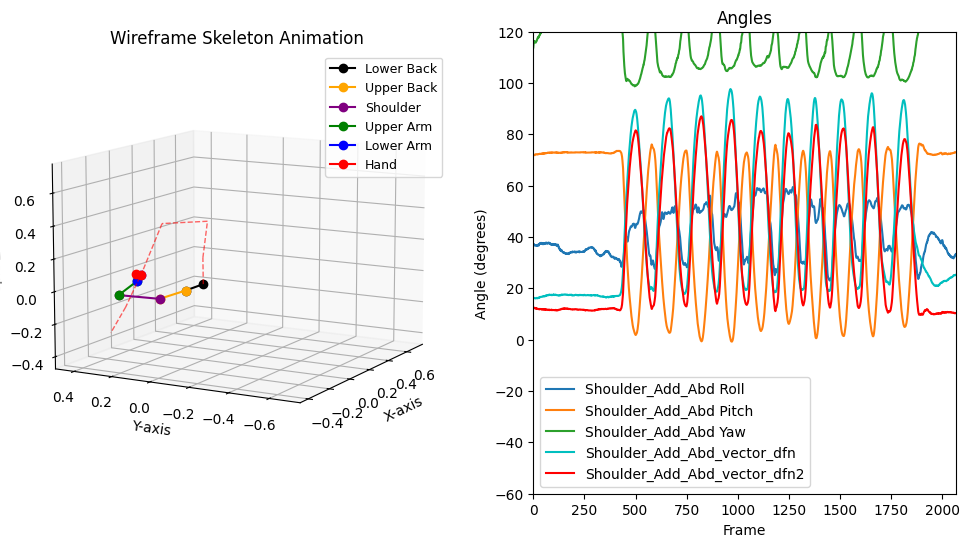

In [19]:
# Plotting Axis Setup for animation and figures
fig = plt.figure(figsize=(12, 6))
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_title("Wireframe Skeleton Animation")
ax3d.set_xlabel("X-axis")
ax3d.set_ylabel("Y-axis")
ax3d.set_zlabel("Z-axis")


axAng = fig.add_subplot(122)
axAng.set_xlim(0, num_frames)
axAng.set_ylim(-60, 120)

axAng.set_xlabel("Frame")
axAng.set_ylabel("Angle (degrees)")
axAng.set_title("Angles")

# Define line objects for each segment
lines = {}
imu_colors = {
    "IMU-1": "red",
    "IMU-2": "blue",
    "IMU-3": "green",
    "IMU-4": "purple",
    "IMU-5": "orange",
    "IMU-6": "black",
}
imu_labels = {
    "IMU-1": "Hand",
    "IMU-2": "Lower Arm",
    "IMU-3": "Upper Arm",
    "IMU-4": "Shoulder",
    "IMU-5": "Upper Back",
    "IMU-6": "Lower Back",
}
for imu, (parent, _) in imu_hierarchy.items():
    color = imu_colors.get(imu, "gray")
    label = imu_labels.get(imu, imu)
    line, = ax3d.plot([], [], [], 'o-', color=color, label=label)
    lines[imu] = line
ax3d.legend(loc='upper right', fontsize=9, frameon=True)

#   (Drawn as a dashed red “skeleton” that never changes.)
ref_lines = {imu: ax3d.plot([], [], [], 'r--', alpha=0.6, lw=1)[0]
             for imu in imu_hierarchy}


#########################################################################################
#   EDIT BELOW
#########################################################################################
 
# initialize the 3 lines:
angle_labels = [

    f"{ANGLE_TO_DISPLAY} Roll",
    f"{ANGLE_TO_DISPLAY} Pitch",
    f"{ANGLE_TO_DISPLAY} Yaw",
]

roll_line, pitch_line, yaw_line = init_angle_plots(
    axAng, angle_labels, mcolors.TABLEAU_COLORS)

# data_series_list param no longer used
abs_angle_line, = axAng.plot([], [], 'c-', label=f"{ANGLE_TO_DISPLAY}_vector_dfn")
abs_angle_line2, = axAng.plot([], [], 'r-', label=f"{ANGLE_TO_DISPLAY}_vector_dfn2")
axAng.legend()

# 3D skeleton plot and interested angle plot
def update_anim(frame):
    """Update function for the animation using pre-computed skeleton positions and angles."""
    
     # --- draw the (static) reference pose on the same axes ------------------------
    for imu, (parent, _) in imu_hierarchy.items():
        if imu in ref_pos and parent in ref_pos:
            p_ref, c_ref = ref_pos[parent], ref_pos[imu]
            ref_lines[imu].set_data([p_ref[0], c_ref[0]], [p_ref[1], c_ref[1]])
            ref_lines[imu].set_3d_properties([p_ref[2], c_ref[2]])
    
    #seg_pos = positions_list[frame]

    seg_pos = positions_list_wrt_n[frame]
    for imu, (parent, _) in imu_hierarchy.items():
        if imu in seg_pos and parent in seg_pos:
            p_pos = seg_pos[parent]
            c_pos = seg_pos[imu]
            lines[imu].set_data([p_pos[0], c_pos[0]], [p_pos[1], c_pos[1]])
            lines[imu].set_3d_properties([p_pos[2], c_pos[2]])
    
    # Update angle plots using precomputed arrays
   
    if ANGLE_TO_DISPLAY == "Shoulder_Add_Abd" or ANGLE_TO_DISPLAY == "Shoulder_Flex_Ext":
        data_array = np.asarray(imu3_shoulder_data_records)        # shape (N, 4)
        abs_angle_line.set_data(np.arange(frame+1), shoulder_vector_angle[:frame+1])
        abs_angle_line2.set_data(np.arange(frame+1), shoulder_2imudot_angle[:frame+1])
        
    elif ANGLE_TO_DISPLAY == "Elbow_Flex_Ext":
        data_array = np.asarray(imu2_elbow_data_records)
        abs_angle_line.set_data(np.arange(frame + 1), elbow_vector_angle[:frame + 1])
        abs_angle_line2.set_data(np.arange(frame+1), elbow_2imudot_angle[:frame+1])
        
    elif ANGLE_TO_DISPLAY == "Back":
        data_array = np.asarray(imu5_trunk_data_records)
        
        
    
    # The order here must match the labels/styles below:
    # convert list of lists → NumPy array for easy slicing
    roll_series    = data_array[:, 1]
    pitch_series   = data_array[:, 2]                     # size N
    yaw_series     = data_array[:, 3]
        
    angle_series = [pitch_series, yaw_series, roll_series,]
    for line, series in zip((pitch_line, yaw_line, roll_line), angle_series):
        line.set_data(np.arange(frame + 1), series[:frame + 1])
    
    
    
        
    axAng.relim()
    axAng.autoscale_view()
    return list(lines.values())+ list(ref_lines.values()) + [pitch_line, yaw_line, roll_line, abs_angle_line, abs_angle_line2]

# Set viewing parameters and equal axes
ax3d.set_xlim(-0.1, 0.4)
ax3d.set_ylim(-0.75, 0.5)
ax3d.set_zlim(-0.1, 0.4)
ax3d.view_init(elev=11, azim=-151)
set_axes_equal(ax3d)

ani = FuncAnimation(fig, update_anim, frames=num_frames, interval=1, blit=False)

# save and show the animation of the kinematic chain movement and the interested angle of the exercise
Writer = writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Your Name'), bitrate=1800)
ani_name = "animation_" + ANGLE_TO_DISPLAY  + ".mov"
ani_path = os.path.join("/home/jafarid/code/fusion/Results/", ani_name)
ani.save(ani_path , writer=writer)
print("Animation saved as: "+ ani_name)

plt.show()

In [20]:
# save the dataframe files of the calculated angles 


df_elbow_deviation = pd.DataFrame({
    "frame": np.arange(num_frames),
    "elbow_deviation_deg": shoulder_2imudot_angle
})

df_shoulder = pd.DataFrame(imu3_shoulder_data_records, 
                             columns=["frame", "imu3_roll", "imu3_pitch", "imu3_yaw"])
df_elbow = pd.DataFrame(elbow_data_records, columns=["frame", "elbow_flexion_extension_deg"])
df_wrist = pd.DataFrame(wrist_data_records, columns=["frame", "sensor", "wrist_pronation_supination_deg"])
df_shoulder_rotation = pd.DataFrame(shoulder_rotation_data_records, columns=["frame", "shoulder_rotation_deg"])
df_imu5_trunk = pd.DataFrame(imu5_trunk_data_records, 
                             columns=["frame", "imu5_roll", "imu5_pitch", "imu5_yaw"])

df_imu4_shoulder = pd.DataFrame(imu4_shoulder_data_records, 
                             columns=["frame", "imu4_roll", "imu4_pitch", "imu4_yaw"])

df_imu6_trunk = pd.DataFrame(imu6_trunk_data_records, columns=["frame", "imu6_roll", "imu6_pitch", "imu6_yaw"])
df_imu5rel6_trunk = pd.DataFrame(trunk_data_records, columns=["frame", "imu5rel6_roll", "imu5rel6_pitch", "imu5rel6_yaw"])

# Pivot wrist data so that each sensor becomes a column
df_wrist_pivot = df_wrist.pivot_table(
    index="frame", 
    columns="sensor", 
    values="wrist_pronation_supination_deg",
    aggfunc='mean'
).reset_index()
df_wrist_pivot.rename(columns={
    "Hand": "wrist_pronation_supination_Hand",
    "Elbow": "wrist_pronation_supination_Elbow"
}, inplace=True)

# Merge all the data
df_combined = pd.merge(df_shoulder, df_elbow, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_wrist_pivot, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_shoulder_rotation, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_imu4_shoulder, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_imu5_trunk, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_imu6_trunk, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_imu5rel6_trunk, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_elbow_deviation, on="frame", how="outer")

# Append shoulder elevation/retraction as new columns
df_shoulder_elevation = pd.DataFrame({
    "frame": np.arange(num_frames),
    "shoulder_elevation_deg": shoulder_elevation
})
df_shoulder_retraction = pd.DataFrame({
    "frame": np.arange(num_frames),
    "shoulder_retraction_deg": shoulder_retraction
})
df_combined = pd.merge(df_combined, df_shoulder_elevation, on="frame", how="outer")
df_combined = pd.merge(df_combined, df_shoulder_retraction, on="frame", how="outer")

# Save consolidated angles/kinematic data to CSV
result_name= folder_name + "_combined_angles.csv"
result_path = os.path.join("/home/jafarid/code/xio/Results/", result_name)
df_combined.to_csv(result_path, index=False)
print("Saved combined angles to:" + result_name)

Saved combined angles to:20250524_173857_combined_angles.csv


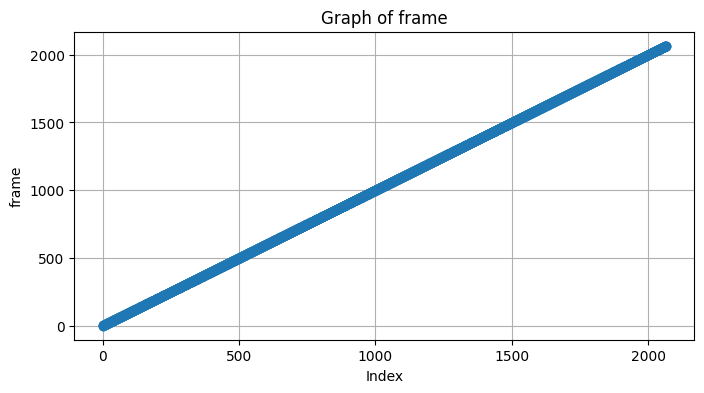

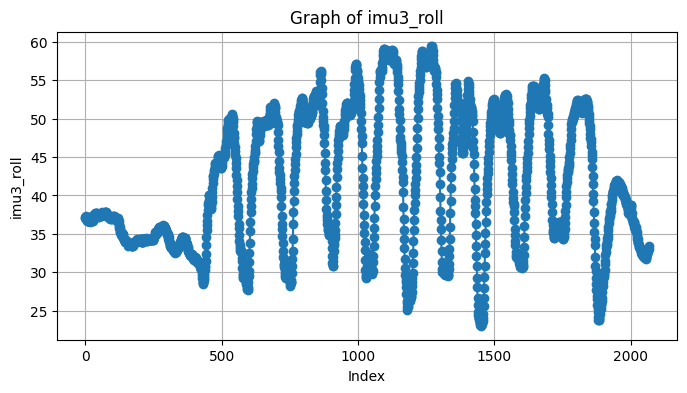

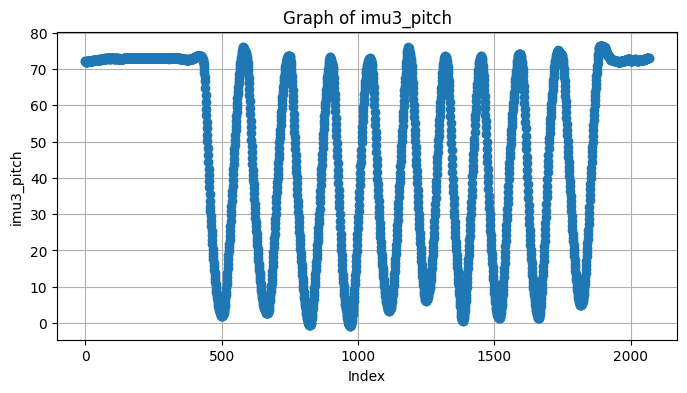

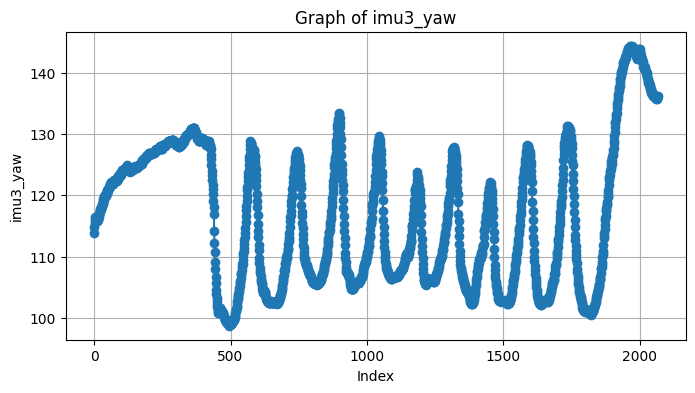

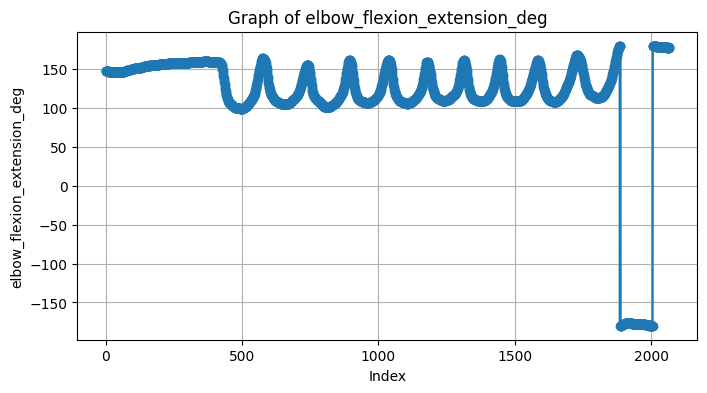

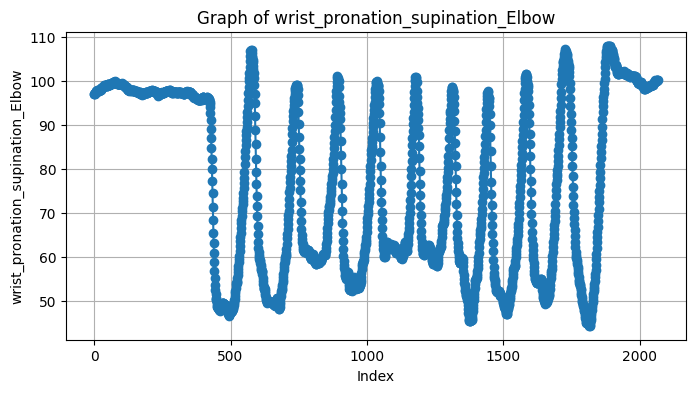

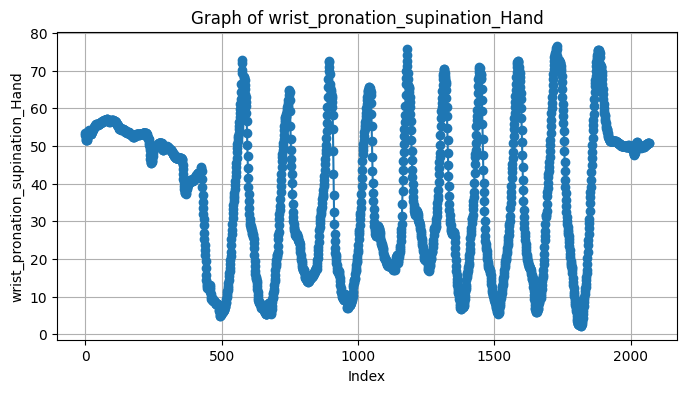

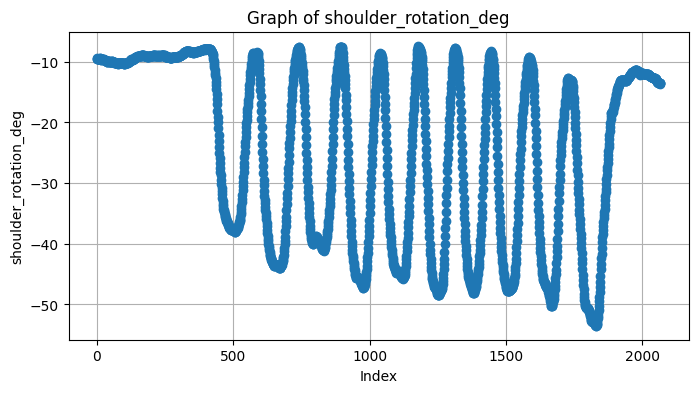

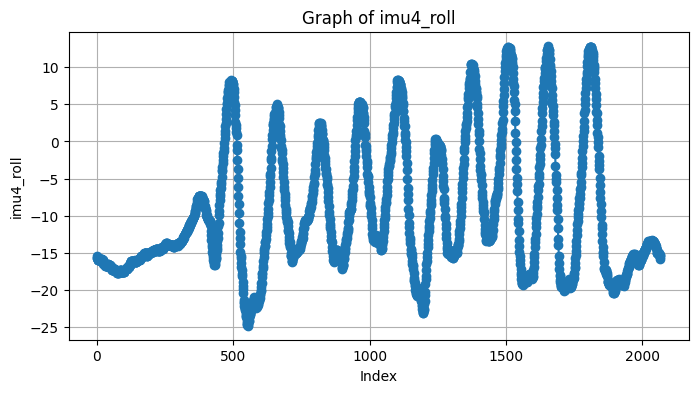

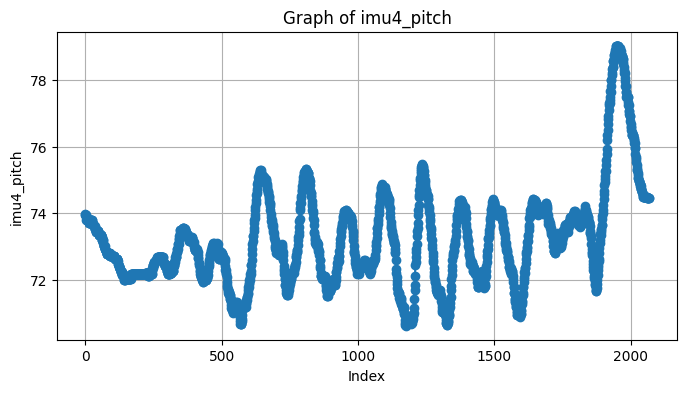

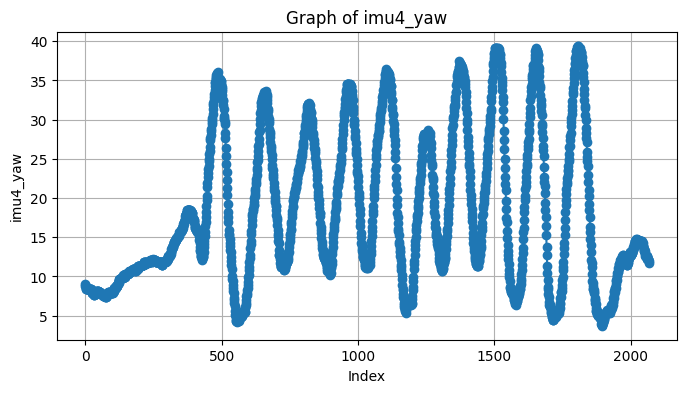

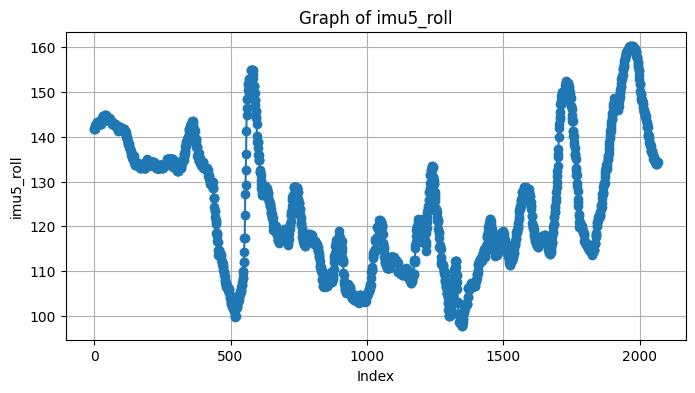

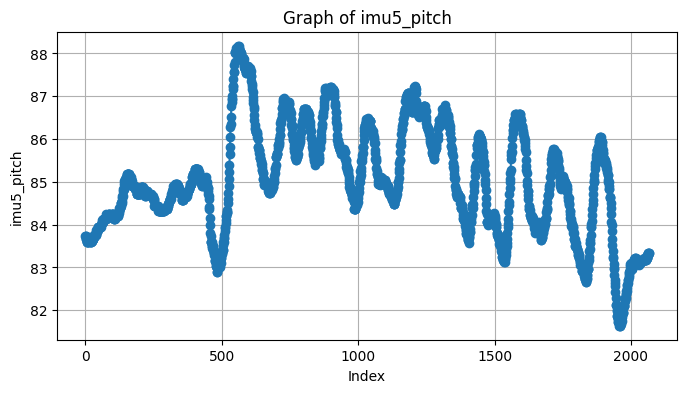

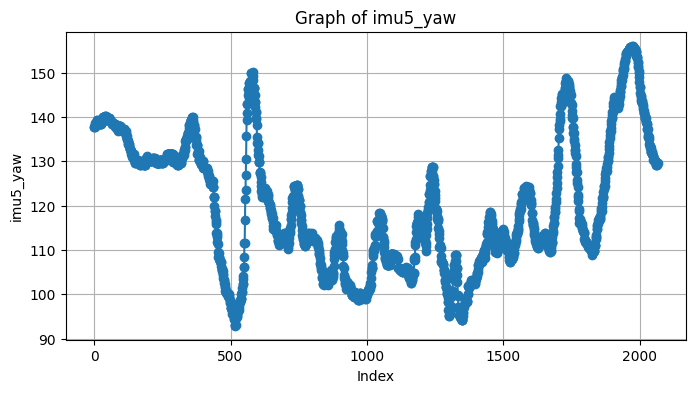

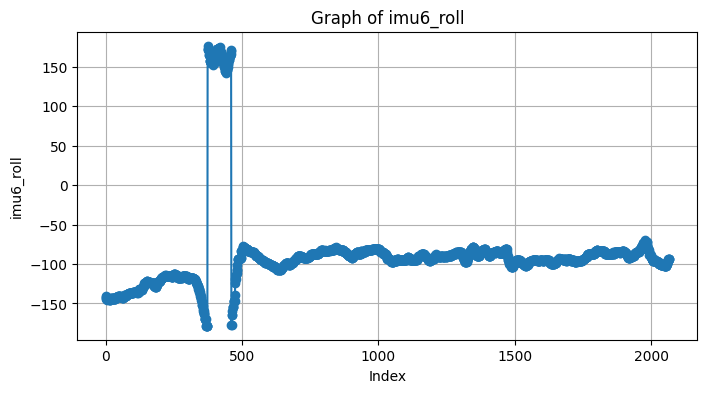

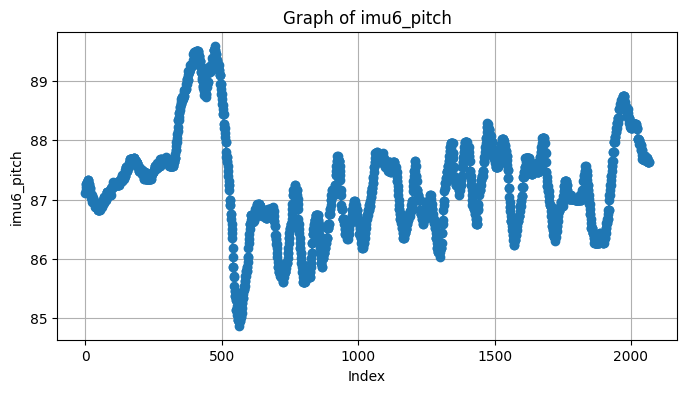

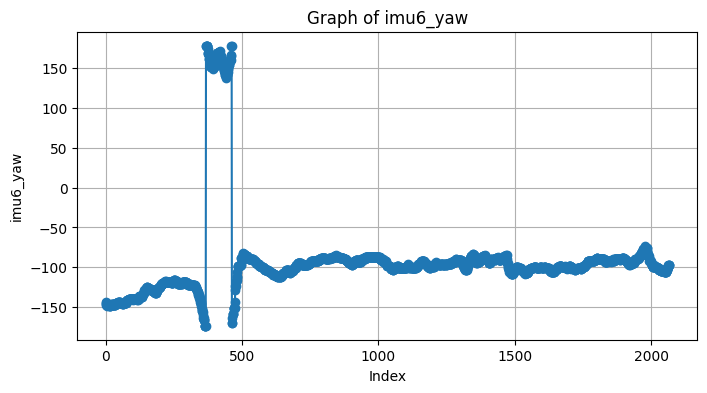

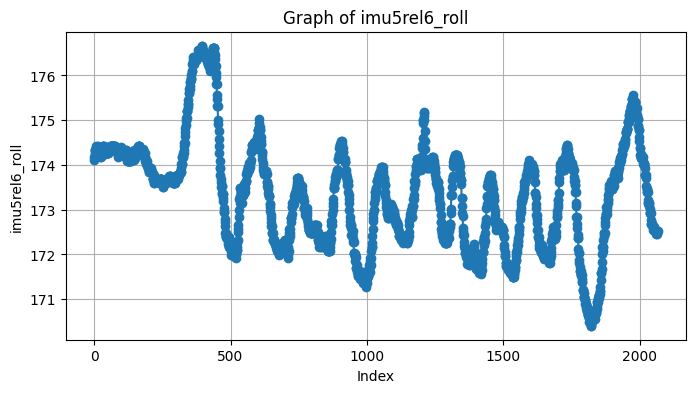

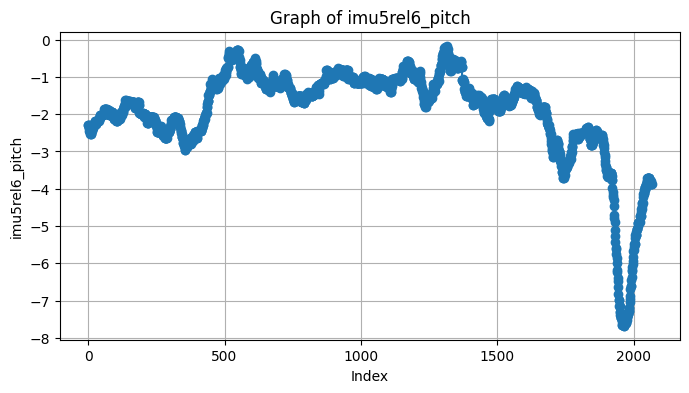

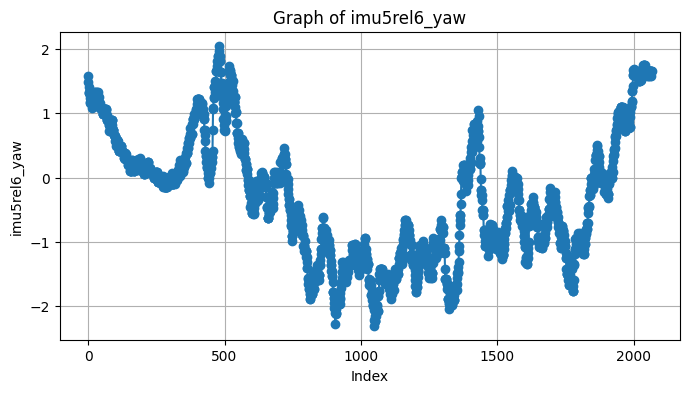

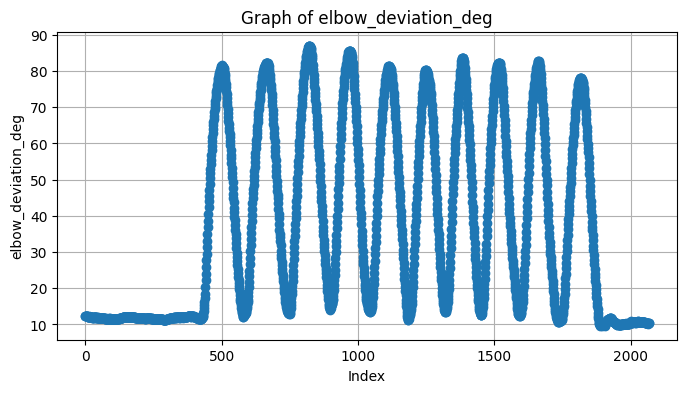

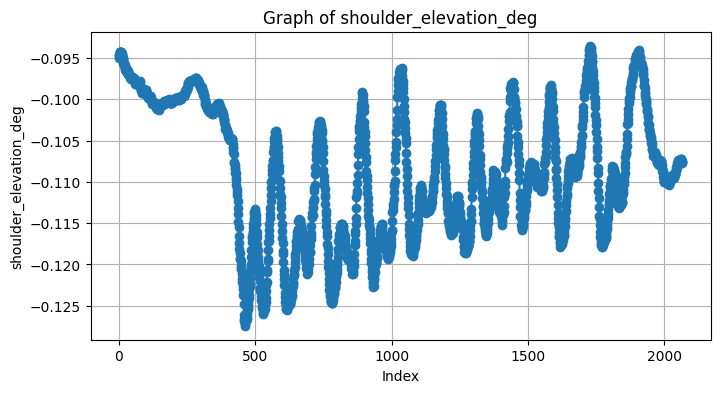

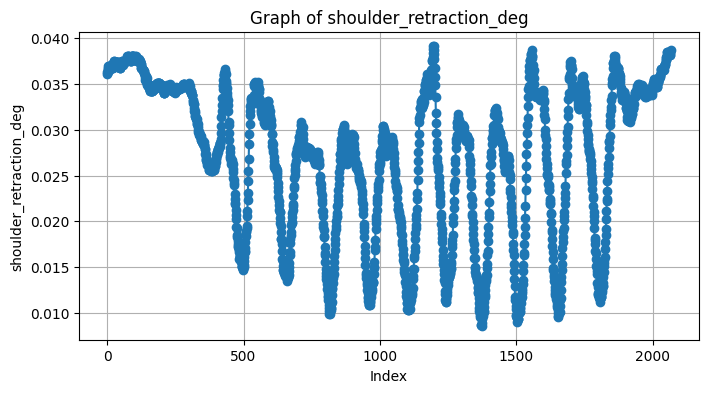

In [21]:

# Load the CSV file
df = pd.read_csv(result_path)

# Display the first few rows to verify the data structure
#print("Data preview:")
#print(df.head())

# Create a separate plot for each column
for col in df.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(df.index, df[col], marker='o')
    plt.title(f"Graph of {col}")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from scipy.spatial.transform import Rotation as R

# -- User-provided data structures (must be defined externally) --
# processed_data: dict of DataFrames with ['q0','q1','q2','q3'] per IMU
# reference_quaternions: dict mapping IMU IDs to [w,x,y,z] reference quaternions
# num_frames: total frames
# ANGLE_TO_DISPLAY: one of 'Elbow_Flex_Ext', 'Shoulder_Flex_Ext', etc.

# Skeleton segment lengths (fractions of user height)
USER_HEIGHT = 1.62  # meters; replace with actual height
lengths = {
    'IMU-6': 0.10 * USER_HEIGHT,  # lower back to pelvis
    'IMU-5': 0.139 * USER_HEIGHT, # lower back to upper back
    'IMU-4': 0.129 * USER_HEIGHT, # upper back to shoulder
    'IMU-3': 0.186 * USER_HEIGHT, # shoulder to elbow
    'IMU-2': 0.145 * USER_HEIGHT, # elbow to wrist
    'IMU-1': 0.108 * USER_HEIGHT, # wrist to hand tip
}

# Define kinematic chain
ROOT_ID = 'ROOT'
imu_chain_order = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']
imu_hierarchy = {
    'IMU-6': (ROOT_ID, lengths['IMU-6']),
    'IMU-5': ('IMU-6', lengths['IMU-5']),
    'IMU-4': ('IMU-5', lengths['IMU-4']),
    'IMU-3': ('IMU-4', lengths['IMU-3']),
    'IMU-2': ('IMU-3', lengths['IMU-2']),
    'IMU-1': ('IMU-2', lengths['IMU-1']),
}

# Initial local direction vectors in reference pose
unit_vectors = {
    #'IMU-6': np.array([0, 0, 1]),
    #'IMU-5': np.array([0, 0, 1]),
    'IMU-6': np.array([-1, 0, 0]),
    'IMU-5': np.array([-1, 0, 0]),
    'IMU-4': np.array([0, 1, 0]),
    'IMU-3': np.array([1, 0, 0]),
    'IMU-2': np.array([1, 0, 0]),
    'IMU-1': np.array([1, 0, 0]),
}

# Precompute reference rotations and positions
reference_rot = {}
ref_pos = {ROOT_ID: np.zeros(3)}
for imu in imu_chain_order:
    q_ref = reference_quaternions[imu]
    quat_xyzw = q_ref[[1,2,3,0]]
    R_ref = R.from_quat(quat_xyzw)
    reference_rot[imu] = R_ref
    parent, dist = imu_hierarchy[imu]
    ref_pos[imu] = R_ref.apply(unit_vectors[imu] * dist) + ref_pos[parent]

# Compute dynamic positions relative to reference
positions_wrt_ref = []
elbow_angles = []
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.zeros(3)}
    for imu in imu_chain_order:
        parent, dist = imu_hierarchy[imu]
        qc = processed_data[imu].iloc[frame][['q0','q1','q2','q3']].values
        quat_xyzw = qc[[1,2,3,0]]
        R_cur = R.from_quat(quat_xyzw)
        R_ref = reference_rot[imu]
        R_rel = R_ref.inv() * R_cur
        seg_pos[imu] = R_rel.apply(unit_vectors[imu] * dist) + seg_pos[parent]
    positions_wrt_ref.append(seg_pos)
    # elbow flexion-extension
    if all(j in seg_pos for j in ['IMU-3','IMU-2','IMU-1']):
        v_upper = seg_pos['IMU-3'] - seg_pos['IMU-2']
        v_fore = seg_pos['IMU-2'] - seg_pos['IMU-1']
        cosang = np.clip(np.dot(v_upper, v_fore) / (np.linalg.norm(v_upper)*np.linalg.norm(v_fore)), -1,1)
        elbow_angles.append(np.degrees(np.arccos(cosang)))
    else:
        elbow_angles.append(0)

# --- Plotting and animation setup ---
fig = plt.figure(figsize=(12,6))
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_title('Skeleton Animation')
ax3d.set_xlabel('X'); ax3d.set_ylabel('Y'); ax3d.set_zlabel('Z')

# Determine axis limits based on all frames and reference
all_pts = []
for seg in positions_wrt_ref:
    for imu in imu_chain_order:
        all_pts.append(seg[imu])
for imu in imu_chain_order:
    all_pts.append(ref_pos[imu])
all_pts = np.vstack(all_pts)
mins = all_pts.min(axis=0)
maxs = all_pts.max(axis=0)
ranges = maxs - mins
margins = ranges * 0.1  # 10% margin
ax3d.set_xlim3d(mins[0]-margins[0], maxs[0]+margins[0])
ax3d.set_ylim3d(mins[1]-margins[1], maxs[1]+margins[1])
ax3d.set_zlim3d(mins[2]-margins[2], maxs[2]+margins[2])

axAng = fig.add_subplot(122)
axAng.set_xlim(0, num_frames)
axAng.set_ylim(0, 180)
axAng.set_xlabel('Frame'); axAng.set_ylabel('Angle (°)')
axAng.set_title('Elbow Flex-Ext')

# Initialize lines
lines = {}; ref_lines = {}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, imu in enumerate(imu_chain_order):
    parent, _ = imu_hierarchy[imu]
    lines[imu], = ax3d.plot([], [], [], 'o-', color=colors[i], label=imu)
    ref_lines[imu], = ax3d.plot([], [], [], 'r--', lw=1)
ax3d.legend()
angle_line, = axAng.plot([], [], 'b-', label='Elbow')
axAng.legend()

# Function to equalize axes scale
def set_axes_equal(ax):
    x_lim, y_lim, z_lim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
    max_range = max(x_lim[1]-x_lim[0], y_lim[1]-y_lim[0], z_lim[1]-z_lim[0])
    mid_x = np.mean(x_lim); mid_y = np.mean(y_lim); mid_z = np.mean(z_lim)
    ax.set_xlim3d(mid_x-max_range/2, mid_x+max_range/2)
    ax.set_ylim3d(mid_y-max_range/2, mid_y+max_range/2)
    ax.set_zlim3d(mid_z-max_range/2, mid_z+max_range/2)

# Animation update
def update(frame):
    # reference skeleton
    for imu in imu_chain_order:
        p0 = ref_pos[imu_hierarchy[imu][0]]
        c0 = ref_pos[imu]
        ref_lines[imu].set_data([p0[0],c0[0]], [p0[1],c0[1]])
        ref_lines[imu].set_3d_properties([p0[2],c0[2]])
    # dynamic skeleton
    seg = positions_wrt_ref[frame]
    for imu in imu_chain_order:
        p = seg[imu_hierarchy[imu][0]]
        c = seg[imu]
        lines[imu].set_data([p[0],c[0]], [p[1],c[1]])
        lines[imu].set_3d_properties([p[2],c[2]])
    # angle plot
    angle_line.set_data(np.arange(frame+1), elbow_angles[:frame+1])
    axAng.relim(); axAng.autoscale_view()
    return list(lines.values()) + list(ref_lines.values()) + [angle_line]

set_axes_equal(ax3d)
ani = FuncAnimation(fig, update, frames=num_frames, interval=50)
Writer = writers['ffmpeg']
ani.save('skeleton_animation.mp4', writer=Writer(fps=30, bitrate=1800))
plt.show()

# Save the animation
ani_name = "animation_copilot_" + folder_name  + ".mov"
ani_path = os.path.join("/home/jafarid/code/xio/Results/", ani_name)
ani.save(ani_path , writer=writer)
print("Animation saved as: "+ ani_name)

NameError: name 'Broken' is not defined